### Installing necessary libraries

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=6f3fcd96c760cc139d369b974a9cabeec36def99ac3e61225b0086f3347d7bba
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import *
from keras.utils.np_utils import to_categorical


### Initialzing spark session

In [ ]:
spark = SparkSession.builder\
    .master("local[*]")\
    .config("spark.sql.repl.eagerEval.enabled", "true") \
    .config("spark.driver.memory", "30g") \
    .getOrCreate()
sc = spark.sparkContext
spark


### Downloading dataset from publicy hosted URL

In [ ]:
!wget https://archive.org/download/intel-dataset_20230726_0457/Intel__Dataset.zip
!unzip -o -q Intel__Dataset


--2023-07-29 06:22:48--  https://archive.org/download/intel-dataset_20230726_0457/Intel__Dataset.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia902706.us.archive.org/22/items/intel-dataset_20230726_0457/Intel__Dataset.zip [following]
--2023-07-29 06:22:49--  https://ia902706.us.archive.org/22/items/intel-dataset_20230726_0457/Intel__Dataset.zip
Resolving ia902706.us.archive.org (ia902706.us.archive.org)... 207.241.228.206
Connecting to ia902706.us.archive.org (ia902706.us.archive.org)|207.241.228.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58300783 (56M) [application/zip]
Saving to: ‘Intel__Dataset.zip’

Intel__Dataset.zip  100%[===================>]  55.60M  21.3MB/s    in 2.6s    

2023-07-29 06:22:52 (21.3 MB/s) - ‘Intel__Dataset.zip’ saved [58300783/58300783]



In [ ]:
data = 'Intel__Dataset'
train_data = f'{data}/seg_train'
test_data = f'{data}/seg_test'
# val_data = f'{data}/seg_pred'

## Custom defined methods:
1. Activation Function
2. Sigmoid Function
3. Cost Function
4. Confusion Matrix
5. Error Functions
6. Derivatives
7. Prediction Function

In [ ]:
# activation layer
def activation(x, f):
    return f(x)

# defining sigmoid function for backward propagation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of Sigmoid function
def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def apply_sigmoid2(x):
    image_data, forward1, activation1, forward2, label = x
    label_pred = activation(forward2, sigmoid)
    print(label_pred.shape)
    return (image_data, forward1, activation1, forward2, label_pred, label)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

# cost function
def get_error(prediction, actual):
    return 0.5 * np.sum(np.power(prediction - actual, 2))

# confusion matrix
def get_metrics(predicted, actual):
    return multilabel_confusion_matrix(actual, predicted)


In [ ]:
# derivatives
def get_error_b2(prediction, actual, y, y_):
    return (prediction - actual) * y_(y)

def get_error_w2(h, error_b2):
    return np.dot(h.T, error_b2)

def get_error_b1(h, error_b2, weights2, y_):
    return np.dot(error_b2, weights2.T) * y_(h)

def get_error_w1(x, error_b1):
    return np.dot(x.T, error_b1)

In [ ]:
# Feed Forward layer
def preforward(x, w, b):
    return np.dot(x, w) + b

# Prediction function
"""
  Takes up random weights W1, W2 and bias values B1, B2
  Trains them to update the values
  Two layer architecture using Sigmoid activation function
"""
def predict(x, W1, B1, W2, B2):
    forward_op1 = preforward(x, W1, B1)
    activation_op1 = sigmoid(forward_op1)
    forward_op2 = preforward(activation_op1, W2, B2)
    prediction = sigmoid(forward_op2)
    return prediction

### Get Images from Directory

In [ ]:
b = 5  # batch size
image_size = (150, 150)  # custom defined image size (to be used for flattening and input layer)
seed = 120  # set seed to ensure same outputs every time the model is developed
image_size_linear = image_size[0] * image_size[1]  # flattened image size

def get_train_images(data):
    # validation dataset would be 20% of the given training set
    return tf.keras.utils.image_dataset_from_directory(data, batch_size=b, image_size=image_size, seed=seed, subset = 'both', validation_split = 0.2)

def get_test_images(data):
    return tf.keras.utils.image_dataset_from_directory(data, batch_size=b, image_size=image_size, seed=seed)


In [ ]:
train_dataset = get_train_images(train_data)
test_dataset = get_test_images(test_data)

validation_dataset = train_dataset[1]
train_dataset = train_dataset[0]

Found 3069 files belonging to 2 classes.
Using 2456 files for training.
Using 613 files for validation.
Found 962 files belonging to 2 classes.


### Class Labels:
1. Buildings
2. Mountain

In [ ]:
class_labels = train_dataset.class_names
print(class_labels)

['buildings', 'mountain']


### Visualize Dataset

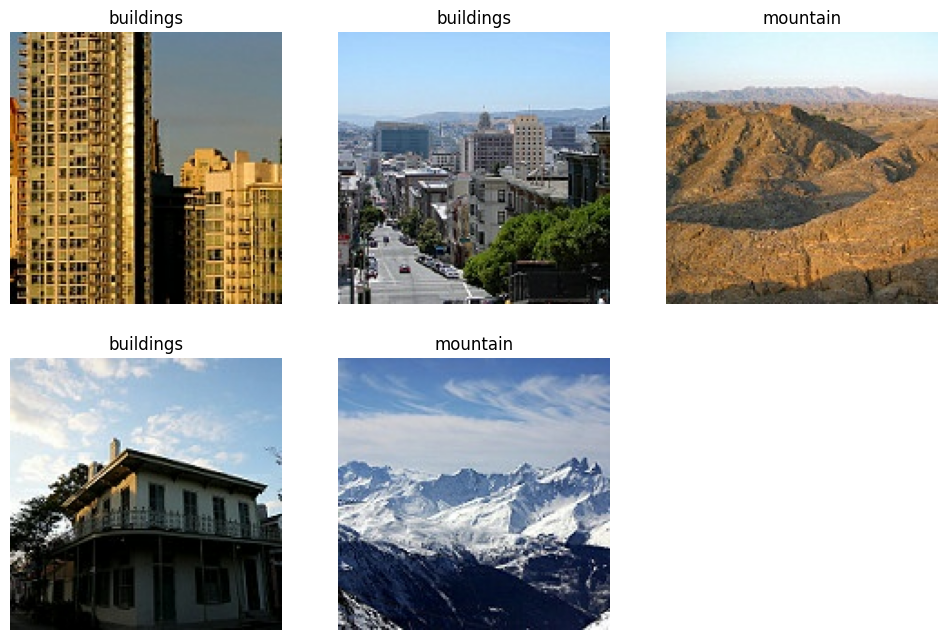

In [ ]:
# visualization using matplotlib
def display(dataset, cmap=None):
    plt.figure(figsize=(12, 12))
    for img, label in dataset.take(1):
      # batch size of 5
      for i in range(b):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"), cmap=cmap)
        plt.title(class_labels[label[i]])
        plt.axis("off")
    plt.show()

display(train_dataset)

### Image Preprocessing

In [ ]:
def image_preprocessing(image, label):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.keras.layers.Rescaling(scale = 1. / 255)(image)
    return image, label

train_ds = train_dataset.map(image_preprocessing)
val_ds = validation_dataset.map(image_preprocessing)
test_ds= test_dataset.map(image_preprocessing)

In [ ]:
def flatten(images):
    return images.reshape(-1, image_size_linear)

def get_labels(label):
    return to_categorical([label], num_classes=len(class_labels), dtype=int)

def get_image_data(dataset):
    image_data = []
    for images, labels in list(dataset.as_numpy_iterator()):
        for image, label in zip(flatten(images), labels):
            k = image.reshape(1, image_size_linear)
            v = get_labels(label).tolist()
            image_data.append((k, v))
    return image_data


image_data = get_image_data(train_ds)

train_rdd = sc.parallelize(image_data)
train_rdd.take(5)


[(array([[0.86194396, 0.86194396, 0.8658652 , ..., 0.18387297, 0.16705844,
          0.2062702 ]], dtype=float32),
  [[0, 1]]),
 (array([[0.49339572, 0.4746416 , 0.47934788, ..., 0.12770905, 0.14562863,
          0.0093349 ]], dtype=float32),
  [[1, 0]]),
 (array([[0.5022483 , 0.48566943, 0.48566943, ..., 0.25538003, 0.24640785,
          0.3082526 ]], dtype=float32),
  [[1, 0]]),
 (array([[0.8895687 , 0.8895687 , 0.89069855, ..., 0.25856906, 0.18010315,
          0.15289061]], dtype=float32),
  [[1, 0]]),
 (array([[0.8580969 , 0.85417575, 0.85417575, ..., 0.73849773, 0.73849773,
          0.74241894]], dtype=float32),
  [[0, 1]])]

### Model Layers

In [ ]:
# Input layer consists of flattened image size neurons (here,it's 22500)
input_layer = image_size_linear

# Since there are six classes, the output layer consists of 2 neurons
output_layer = len(class_labels)

### Mapping functions

In [ ]:
def apply_forward1(x, weights1, bias1):
    image_data, label = x
    forward1 = preforward(image_data, weights1, bias1)
    return (image_data, forward1, label)

def apply_sigmoid1(x):
    image_data, forward1, label = x
    activation1 = activation(forward1, sigmoid)
    return (image_data, forward1, activation1, label)

def apply_forward2(x, weights2, bias2):
    image_data, forward1, activation1, label = x
    forward2 = preforward(activation1, weights2, bias2)
    return (image_data, forward1, activation1, forward2, label)

def apply_sigmoid2(x):
    image_data, forward1, activation1, forward2, label = x
    label_pred = activation(forward2, sigmoid)
    return (image_data, forward1, activation1, forward2, label_pred, label)

def apply_forward3(x, weights3, bias3):
    image_data, forward1, activation1, forward2, activation2, label = x
    forward3 = preforward(activation2, weights3, bias3)
    return (image_data, forward1, activation1, forward2, activation2, forward3, label)

def apply_sigmoid3(x):
    image_data, forward1, activation1, forward2, activation2, forward3, label = x
    label_pred = activation(forward3, sigmoid)
    return (image_data, forward1, activation1, forward2, activation2, forward3, label_pred, label)

def estimate_error_b2(x):
    image_data, forward1, activation1, forward2, label_pred, label = x
    error = get_error(label_pred, label)
    error_b2 = get_error_b2(label_pred, label, forward2, sigmoid_derivative)
    correct_prediction = int(np.argmax(label_pred) == np.argmax(label))
    return (image_data, forward1, activation1, error, error_b2, correct_prediction)

def estimate_error_w2(x):
    image_data, forward1, activation1, error, error_b2, correct_prediction = x
    error_w2 = get_error_w2(activation1, error_b2)
    return (image_data, forward1, error, error_b2, error_w2, correct_prediction)

def estimate_error_b1(x, weights2):
    image_data, forward1, error, error_b2, error_w2, correct_prediction = x
    error_b1 = get_error_b1(forward1,  error_b2, weights2, sigmoid_derivative)
    return (image_data, error, error_b2, error_w2, error_b1, correct_prediction)

def estimate_error_w1(x):
    image_data, error, error_b2, error_w2, error_b1, correct_prediction = x
    error_w1 = get_error_w1(image_data, error_b1)
    return (error, error_b2, error_w2, error_b1, error_w1, correct_prediction, 1)

def update_weights_and_bias(learning_rate, weights1, weights2, bias1, bias2, error_b2, error_w2, error_b1, error_w1, num_imgs):
    new_bias2 = bias2 - (learning_rate * (error_b2 / num_imgs))
    new_weight2 = weights2 - (learning_rate * (error_w2 / num_imgs))
    new_bias1 = bias1 - (learning_rate * (error_b1 / num_imgs))
    new_weight1 = weights1 - (learning_rate * (error_w1 / num_imgs))

    return (new_weight1, new_bias1, new_weight2, new_bias2)

def reduce_util(x, y):
    x_error, b2_x_err, w2_x_err, b1_x_err, w1_x_err, correct_prediction_x, count_x = x
    y_error, b2_y_err, w2_y_err, b1_y_err, w1_y_err, correct_prediction_y, count_y = y
    error = x_error + y_error
    error_b2 = b2_x_err + b2_y_err
    error_w2 = w2_x_err + w2_y_err
    error_b1 = b1_x_err + b1_y_err
    error_w1 = w1_x_err + w1_y_err
    correct_predictions = correct_prediction_x + correct_prediction_y
    num_imgs = count_x + count_y
    return (error, error_b2, error_w2, error_b1, error_w1, correct_predictions, num_imgs)

def get_random_weights(start, end, initial_bias):
  return np.random.rand(start, end) - initial_bias


### Model training

In [ ]:
# Fit method takes model hyperparameters
def fit(itr, learning_rate, hidden_layers):

  initial_bias = 0.5

  # Get random initial weights and bias
  weights1 = get_random_weights(input_layer, hidden_layers, initial_bias)
  weights2 = get_random_weights(hidden_layers, output_layer, initial_bias)
  bias1 = get_random_weights(1, hidden_layers, initial_bias)
  bias2 = get_random_weights(1, output_layer, initial_bias)

  print(f"Hidden layers={hidden_layers}, Learning Rate={learning_rate}, Max Iterations={itr}")
  print("_________________________________________________________________________________________")

  accuracies = []
  errors = []

  for i in range(itr):
      output = train_rdd \
          .map(lambda x: apply_forward1(x, weights1, bias1)) \
          .map(lambda x: apply_sigmoid1(x)) \
          .map(lambda x: apply_forward2(x, weights2, bias2)) \
          .map(lambda x: apply_sigmoid2(x)) \
          .map(lambda x: estimate_error_b2(x)) \
          .map(lambda x: estimate_error_w2(x)) \
          .map(lambda x: estimate_error_b1(x, weights2)) \
          .map(lambda x: estimate_error_w1(x)) \
          .reduce(reduce_util)

      iteration_accuracy = output[5] / output[6]
      iteration_error = output[0] / output[6]

      accuracies.append(iteration_accuracy)
      errors.append(iteration_error)

      weights1, bias1, weights2, bias2 = update_weights_and_bias(learning_rate, weights1, weights2, bias1, bias2, output[1], output[2], output[3], output[4], output[6])

  # Performance metrices
  print(f"   Iterations: {itr} | Accuracy: {accuracies[-1]:.4f} | Error: {errors[-1]:.4f}")
  print("-----------------------------------------------------------------------------------------")

  return weights1, weights2, bias1, bias2, accuracies, errors

### Model predictions

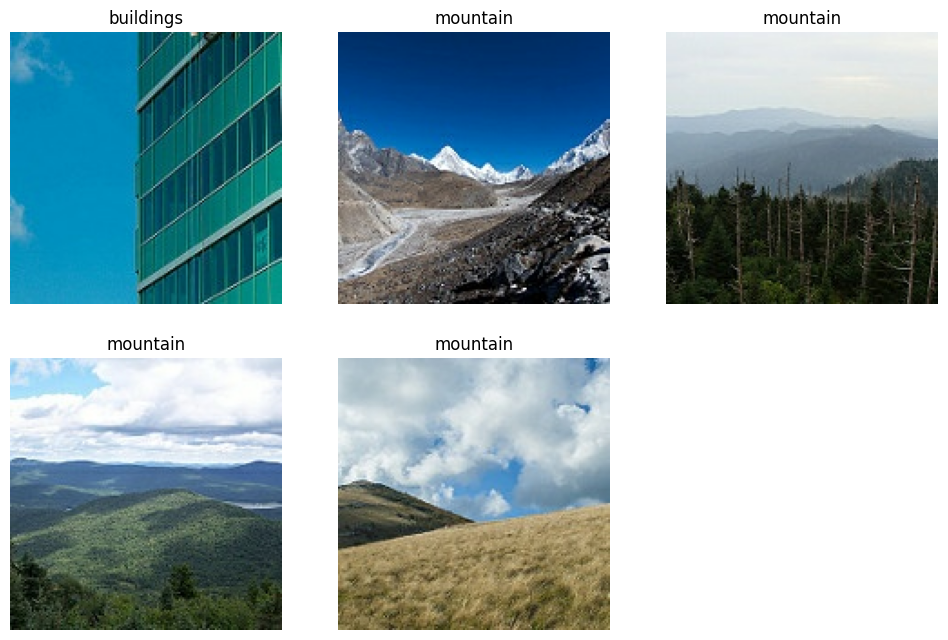

In [ ]:
test_image_data = get_image_data(test_dataset)
test_rdd = sc.parallelize(test_image_data)

display(test_dataset)

In [ ]:
def prediction_mapper(x, weights1, bias1, weights2, bias2):
  prediction = predict(x[0], weights1, bias1, weights2, bias2)
  error = get_error(prediction, x[1])
  correct_prediction = int(np.argmax(prediction) == np.argmax(x[1]))
  return (correct_prediction, error, 1)

def prediction_reducer(x, y):
    return (x[0] + y[0], x[1] + y[1], x[2] + y[2])

### Hyperparameter Tuning

In [ ]:
iterations = [20, 30]
learning_rates = [0.2, 0.3]
hidden_layers = [32, 64, 128]

i = 0

model_params = []

train_accuracies_list = []
train_errors_list = []

for hidden_layer in hidden_layers:
  for lr in learning_rates:
    i+=1
    for itr in iterations:

      # Model training
      w1, w2, bias1, bias2, train_accuracy, train_error = fit(itr, lr, hidden_layer)

      # Model prediction
      res = test_rdd.map(lambda x: prediction_mapper(x, w1, bias1, w2, bias2)).reduce(prediction_reducer)
      total_error = res[0]
      correct_predictions = res[1]
      count = res[2]

      train_accuracies_list.append(train_accuracy)
      train_errors_list.append(train_error)

      test_error = total_error / count
      test_accuracy = correct_predictions / count

      model_params.append({
          'max_iterations': itr,
          'rate': lr,
          'hidden_layers': hidden_layer,
          'train_loss': np.min(train_error),
          'train_accuracy': np.max(train_accuracy),
          'test_loss': test_error,
          'test_accuracy': test_accuracy
      })

Hidden layers=32, Learning Rate=0.2, Max Iterations=20
_________________________________________________________________________________________
   Iterations: 20 | Accuracy: 0.6498 | Error: 0.2374
-----------------------------------------------------------------------------------------
Hidden layers=32, Learning Rate=0.2, Max Iterations=30
_________________________________________________________________________________________
   Iterations: 30 | Accuracy: 0.6250 | Error: 0.2379
-----------------------------------------------------------------------------------------
Hidden layers=32, Learning Rate=0.3, Max Iterations=20
_________________________________________________________________________________________
   Iterations: 20 | Accuracy: 0.6124 | Error: 0.2446
-----------------------------------------------------------------------------------------
Hidden layers=32, Learning Rate=0.3, Max Iterations=30
_________________________________________________________________________________

### Model Performance Parameters

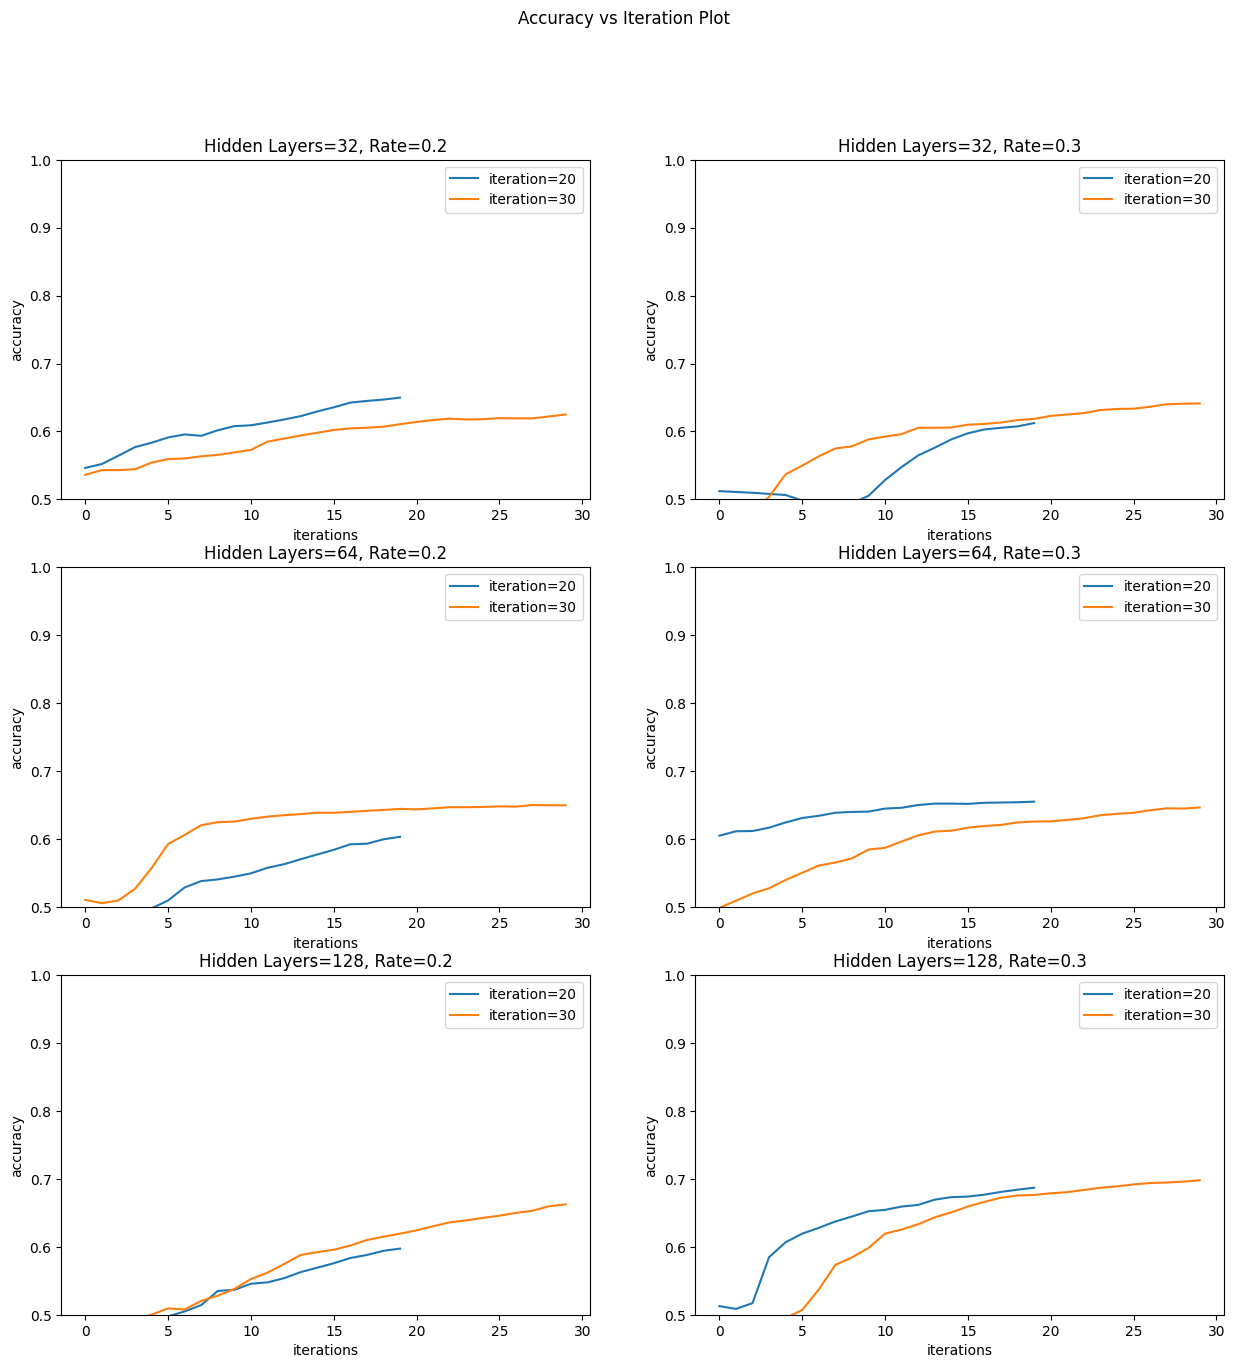

In [ ]:
plt.subplots(len(hidden_layers), len(learning_rates), figsize=(15, 15))
plt.suptitle(f"Accuracy vs Iteration Plot")

idx = 0
subplot = 0

for hidden_layer in hidden_layers:
  for learning_rate in learning_rates:
    subplot+=1
    plt.subplot(len(hidden_layers), len(learning_rates), subplot)
    for i in iterations:
      label=f"iteration={i}"
      plt.ylim([0.5, 1])
      plt.plot(train_accuracies_list[idx], label=label)
      idx += 1

    plt.legend(loc='upper right')
    plt.title(f"Hidden Layers={hidden_layer}, Rate={learning_rate}")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")

### Best Model Parameters

In [ ]:
params_df = pd.DataFrame(model_params)
best_hyperparams = params_df.loc[params_df['test_accuracy'].idxmax()]
print("Best Model Hyperparameters:")
print(best_hyperparams.to_dict())

Best Model Hyperparameters:
{'max_iterations': 30.0, 'rate': 0.2, 'hidden_layers': 128.0, 'train_loss': 0.22780615912355123, 'train_accuracy': 0.6624592833876222, 'test_loss': 0.4656964656964657, 'test_accuracy': 0.3214938220471057}


### Training and testing loss

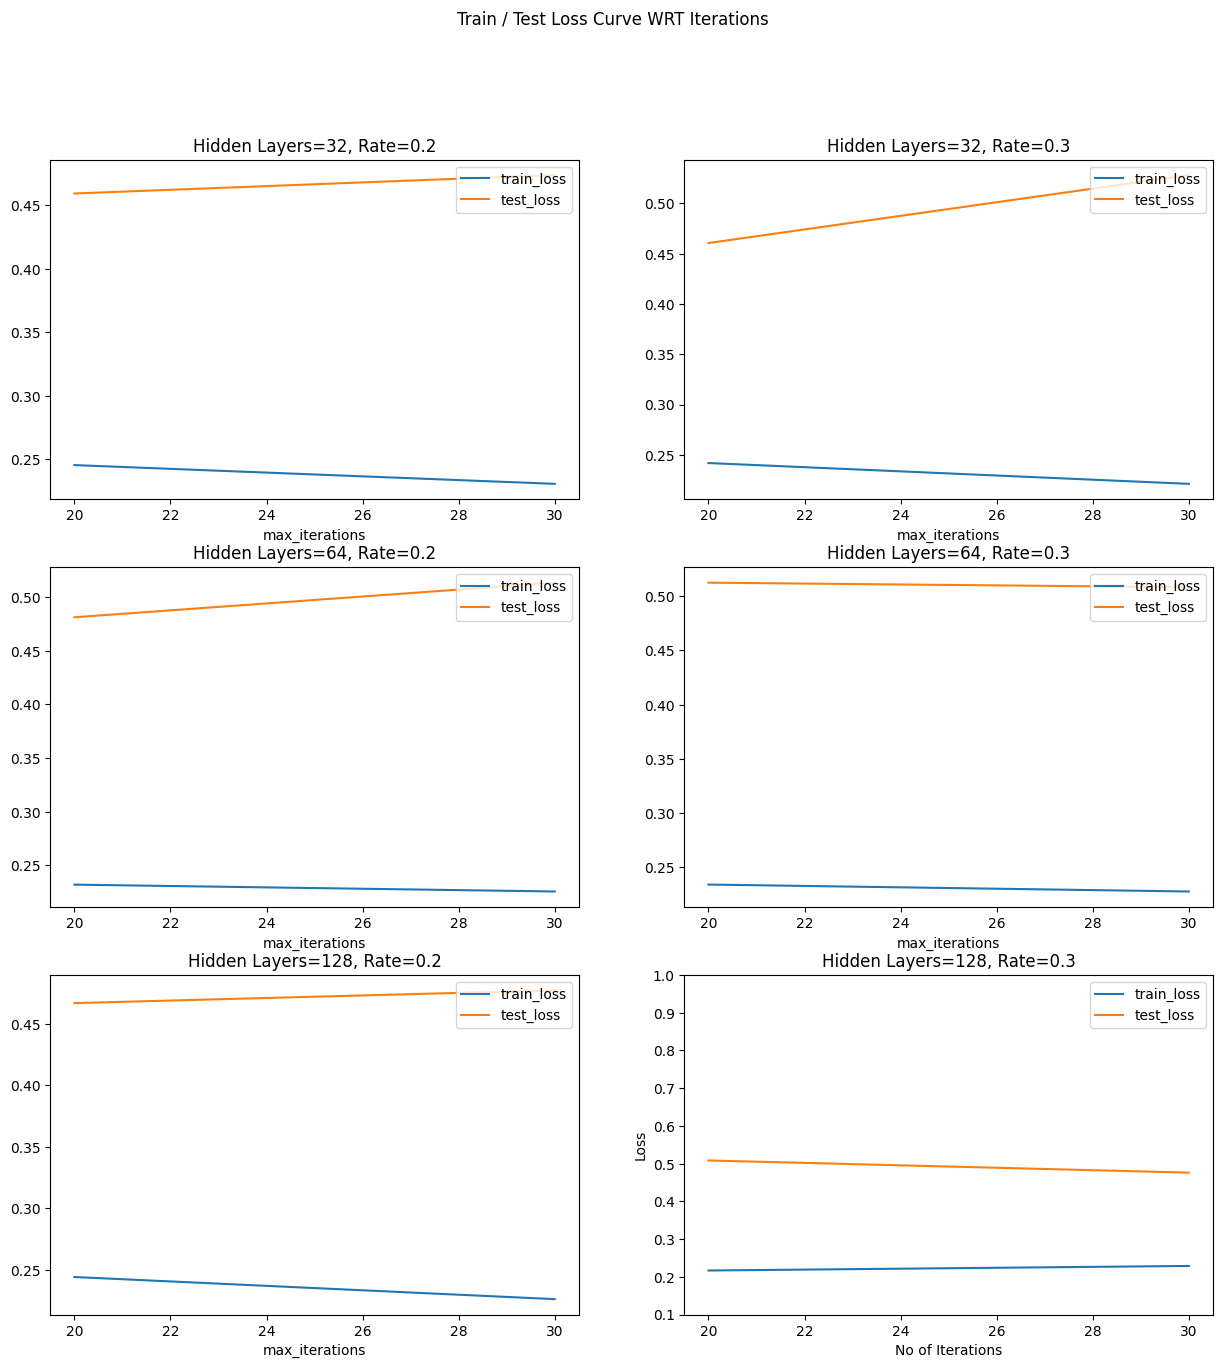

In [ ]:
i = 0

z, ax = plt.subplots(len(hidden_layers), len(learning_rates), figsize=(15, 15))
plt.suptitle(f"Train / Test Loss Curve WRT Iterations")

for i, h in enumerate(hidden_layers):
  for j, l in enumerate(learning_rates):
    filtered_df = params_df[(params_df['rate'] == l) & (params_df['hidden_layers'] == h)]
    axis = ax[i][j]
    filtered_df.plot(x='max_iterations', y=['train_loss', 'test_loss'], ax=axis, title=f"Hidden Layers={h}, Rate={l}")
    axis.legend(loc='upper right')
    plt.xlabel("No of Iterations")
    plt.ylim([0.1, 1])
    plt.ylabel("Loss")

### Model parameters tabularization

In [ ]:
params_df.head(100)

,max_iterations,rate,hidden_layers,train_loss,train_accuracy,test_loss,test_accuracy
0,20,0.2,32,0.237422,0.649837,0.482328,0.275362
1,30,0.2,32,0.237875,0.625000,0.494802,0.268286
2,20,0.3,32,0.244604,0.612378,0.527027,0.263201
3,30,0.3,32,0.235981,0.641287,0.512474,0.263843
4,20,0.2,64,0.247650,0.603420,0.511435,0.274667
5,30,0.2,64,0.227156,0.650244,0.483368,0.302072
6,20,0.3,64,0.224887,0.655130,0.484407,0.297065
7,30,0.3,64,0.226300,0.646580,0.521830,0.279730
8,20,0.2,128,0.252797,0.597313,0.462578,0.299584
9,30,0.2,128,0.227806,0.662459,0.465696,0.321494
